### Setup

In [1]:
import os, pickle, sys, re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk

from itertools import product
from tqdm import tqdm_notebook, tnrange
from bisect import bisect_left
from statistics import mean, stdev
from math import log

### Function definitions

In [2]:
def load_corpus( path_to_corpus_dir ):
    """
    Returns the list of files in the input directory and the files' compiled contents.
    
    Arguments:
    
        path_to_corpus_dir: str or Path obj to the directory containing the files.
        
    Returns:
    
        files_list: list of paths to each file in the input directory.
        
        corpus_contents: list of strings, where each string is one file's contents.
        
    """
    try:
        assert os.path.isdir( path_to_corpus_dir )
    except AssertionError:
        if 'win' in sys.platform:
            new_path= '\\\\?\\' + path_to_corpus_dir
            path_to_corpus_dir = new_path
            assert os.path.isdir( path_to_corpus_dir )
    
    files_list =    [ os.path.join( path_to_corpus_dir, f ) for f in os.listdir( path_to_corpus_dir )
                      if os.path.isfile( os.path.join( path_to_corpus_dir, f ) ) and '.txt' in f
                    ]

    corpus_contents = []
    for f in files_list:
        with open( f, 'r', encoding="utf8" ) as handle:
            corpus_contents.append( handle.readlines() )
    
    return files_list, corpus_contents
    

In [3]:
pos_test_list, pos_contents = load_corpus( os.path.join( os.getcwd(), 'train', 'pos' ) )
assert len( pos_test_list ) == 12500

### Sanity-checking the output of load_corpus

In [4]:
path_ptc = '\\\\?\\'+os.path.join( os.getcwd(), 'train', 'pos' )
ptc_files = [ os.path.join( path_ptc, f ) for f in os.listdir( path_ptc ) 
             if os.path.isfile( os.path.join( path_ptc, f ) )
             and '.txt' in f 
            ]

assert len( ptc_files ) == 12500
assert set( [ '\\\\?\\'+t for t in pos_test_list ] ) == set( ptc_files )

### Loading negative reviews corpus

In [5]:
neg_test_list, neg_contents = load_corpus( os.path.join( os.getcwd(), 'train', 'neg' ) )
assert len( neg_test_list ) == 12500

### Some basic plots

(52, 13704)


<IPython.core.display.Javascript object>


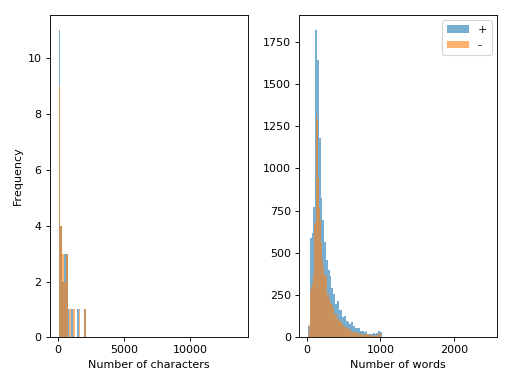

In [6]:
%matplotlib notebook

pf_char_lengths, nf_char_lengths = [ len( pf[0] ) for pf in pos_contents ], [ len( nf[0] ) for nf in neg_contents ]
pf_word_lengths, nf_word_lengths = [ len( pf[0].split() ) for pf in pos_contents ], [ len( nf[0].split() ) for nf in neg_contents ]

# setting up histogram bins
char_bin_range = (  min( min( pf_char_lengths ), min( nf_char_lengths ) ),
                    max( max( pf_char_lengths ), max( nf_char_lengths ) )             
                 )

char_length_mean = mean( pf_char_lengths + nf_char_lengths )
char_length_stdev = stdev( pf_char_lengths + nf_char_lengths )

char_bins = np.linspace( char_bin_range[0], char_bin_range[1], num=100, endpoint=True )

print( char_bin_range )

pos_char_length_freq, _ = np.histogram( pf_char_lengths, bins=char_bins )
neg_char_length_freq, _ = np.histogram( nf_char_lengths, bins=char_bins )

assert( np.sum( pos_char_length_freq ) == np.sum( neg_char_length_freq ) )

fig, ax = plt.subplots(1,2)
ax[0].hist( pos_char_length_freq, bins=char_bins, alpha=0.6, label='+' )
ax[0].hist( neg_char_length_freq, bins=char_bins, alpha=0.6, label='-' )
ax[0].set_ylabel("Frequency")
ax[0].set_xlabel("Number of characters")

ax[1].hist( pf_word_lengths, bins=100, alpha=0.6, label='+' )
ax[1].hist( nf_word_lengths, bins=100, alpha=0.6, label='-' )
ax[1].set_xlabel("Number of words")

plt.tight_layout()
plt.legend(loc="upper right")
plt.show()


### Exploring negative contractions

In [7]:
not_contraction_count_p = sum( [ 1 for pfc in pos_contents if "n't" in pfc[0] ] )
not_contraction_count_f = sum( [ 1 for nfc in neg_contents if "n't" in nfc[0] ] )
print( f"{not_contraction_count_p} positive reviews have >= 1 negative contraction, {not_contraction_count_f} negative reviews have >= 1 negative contraction" )

6552 positive reviews have >= 1 negative contraction, 8283 negative reviews have >= 1 negative contraction


In [8]:
decontracted_pos_contents, decontracted_neg_contents = [],[]
for review in pos_contents:
    decontracted_review = re.sub( r"n't", r" not ", review[0] )
    decontracted_pos_contents.extend( [ decontracted_review ] )

for review in neg_contents:
    decontracted_review = re.sub( r"n't", r" not ", review[0] )
    decontracted_neg_contents.extend( [ decontracted_review ] )

print( pos_contents[0] )
print( decontracted_pos_contents[0] )

['Bromwell High is a cartoon comedy. It ran at the same time as some other programs about school life, such as "Teachers". My 35 years in the teaching profession lead me to believe that Bromwell High\'s satire is much closer to reality than is "Teachers". The scramble to survive financially, the insightful students who can see right through their pathetic teachers\' pomp, the pettiness of the whole situation, all remind me of the schools I knew and their students. When I saw the episode in which a student repeatedly tried to burn down the school, I immediately recalled ......... at .......... High. A classic line: INSPECTOR: I\'m here to sack one of your teachers. STUDENT: Welcome to Bromwell High. I expect that many adults of my age think that Bromwell High is far fetched. What a pity that it isn\'t!']
Bromwell High is a cartoon comedy. It ran at the same time as some other programs about school life, such as "Teachers". My 35 years in the teaching profession lead me to believe that B

### Lemmatization

In [9]:
from nltk.stem import WordNetLemmatizer
wn_lemmatizer = WordNetLemmatizer()

In [10]:
lemmatized_decontracted_pos_contents = []
for dpc in decontracted_pos_contents:
    ldpc = dpc.lower() # lowercases
    regularizer = re.compile( '[^a-zA-Z0-9 ]' ) # will only keep alphanum and spaces
    an_ldpc = regularizer.sub( '', ldpc ) # enacts regularizer
    lemmatized_anldpc = []
    for word in an_ldpc.split(): 
        #print( word )
        #print( wn_lemmatizer.lemmatize( word ) )
        lemmatized_anldpc.append( wn_lemmatizer.lemmatize( word ) )
    lemmatized_decontracted_pos_contents.append( ' '.join( lemmatized_anldpc ) )

In [11]:
lemmatized_decontracted_pos_contents[0]

'bromwell high is a cartoon comedy it ran at the same time a some other program about school life such a teacher my 35 year in the teaching profession lead me to believe that bromwell high satire is much closer to reality than is teacher the scramble to survive financially the insightful student who can see right through their pathetic teacher pomp the pettiness of the whole situation all remind me of the school i knew and their student when i saw the episode in which a student repeatedly tried to burn down the school i immediately recalled at high a classic line inspector im here to sack one of your teacher student welcome to bromwell high i expect that many adult of my age think that bromwell high is far fetched what a pity that it is not'

In [12]:
lemmatized_decontracted_neg_contents = []
for dpc in decontracted_neg_contents:
    ldpc = dpc.lower() # lowercases
    regularizer = re.compile( '[^a-zA-Z0-9 ]' ) # will only keep alphanum and spaces
    an_ldpc = regularizer.sub( '', ldpc ) # enacts regularizer
    lemmatized_anldpc = []
    for word in an_ldpc.split(): 
        #print( word )
        #print( wn_lemmatizer.lemmatize( word ) )
        lemmatized_anldpc.append( wn_lemmatizer.lemmatize( word ) )
    lemmatized_decontracted_neg_contents.append( ' '.join( lemmatized_anldpc ) )

### Some useful text processing functions

In [13]:
def has_some_alphanumeric_characters( line ):
    """
    Returns True/False depending on whether the input line (string) contains at least one alphabetic character.
    
    Input:
        
        line: a string.
        
    Returns:
        boolean True/False
    """
    if re.search('[a-zA-Z]', line):
        return True
    else:
        return False

def word_tokenize( line: str ):
    """
    Tokenizes input string into words (where each word has >= 1 letter).
    
    Input:
        
        line: string to tokenize into words.
            
    Returns: 
        
        a list of all tokens with >= 1 alphabetic character.
        
    """
    return [ word for word in nltk.word_tokenize( line ) if has_some_alphanumeric_characters( word ) ]


In [14]:
### Brute force approach
#### lemmatize and vectorize whole corpus, find which words have a stat' sig' difference in distribution.

### Using Minqing Hu and Bing Liu's positive/negative lemma lexicon and Warriner et al's "word valence" ratings
#### Note: if you want to use this, you MUST lemmatize your input first.

In [60]:
def factor_by_wea_valence( word:str, valence_df:pd.DataFrame, valence_mean:float, missing_val=0.0 ):
    """
    OGW.
    """
    try:
        return float( valence_df.loc[word, "V.Mean.Sum"] ) - valence_mean
    except KeyError:
        return missing_val

def mhblwea_pn_ratio( text:str, pos_lems, neg_lems, valence_df=None, valence_mean=None ):
    """
    OGW.
    """
    words = word_tokenize( text )
    denom = len( words )
    pos_lems_len, neg_lems_len = len( pos_lems ), len( neg_lems )
    # binary search for each word
    #pos_contrib = sum( [ factor_by_wea_valence( word, valence_df, valence_mean ) for word in words if ( bisect_left( pos_lems, word ) < pos_lems_len ) and ( pos_lems[ bisect_left( pos_lems, word ) ] == word ) ] ) 
    #neg_contrib = sum( [ factor_by_wea_valence( word, valence_df, valence_mean ) for word in words if ( bisect_left( neg_lems, word ) < neg_lems_len ) and ( neg_lems[ bisect_left( neg_lems, word ) ] == word ) ] )
    pos_contrib, neg_contrib = 0.0, 0.0
    for i,word in enumerate( words ):
        try:
            if pos_lems[ bisect_left( pos_lems, word ) ] == word :
                word_pos_contrib = factor_by_wea_valence( word, valence_df, valence_mean )
                if ( 'not' in words[ i-2:i ] ):
                    word_pos_contrib *= -1.0
                pos_contrib += word_pos_contrib
            else: # word not in pos_lems
                pos_contrib += 0.0
        except IndexError: # word is more z-ish than z-most word in pos_lems
            pos_contrib += 0.0
        try:
            if neg_lems[ bisect_left( neg_lems, word ) ] == word :
                word_neg_contrib = factor_by_wea_valence( word, valence_df, valence_mean ) 
                if ( 'not' in words[ i-2:i ] ):
                    word_neg_contrib *= -1.0
                neg_contrib += word_neg_contrib
            else:
                neg_contrib += 0.0
        except IndexError: # word is more z-ish than z-most word in neg_lems
            neg_contrib += 0.0
            
    #return ( pos_contrib + neg_contrib ) / denom
    return log( pos_contrib/(1.0E-06 + -1.0*neg_contrib) )

def mhblwea_votes( text:str, pos_lems, neg_lems, valence_df=None, valence_mean=None, ntop=10, negation=False ):
    """
    OGW.
    """
    words = word_tokenize( text )
    denom = len( words )
    pos_lems_len, neg_lems_len = len( pos_lems ), len( neg_lems )
    # binary search for each word
    #pos_contrib = sum( [ factor_by_wea_valence( word, valence_df, valence_mean ) for word in words if ( bisect_left( pos_lems, word ) < pos_lems_len ) and ( pos_lems[ bisect_left( pos_lems, word ) ] == word ) ] ) 
    #neg_contrib = sum( [ factor_by_wea_valence( word, valence_df, valence_mean ) for word in words if ( bisect_left( neg_lems, word ) < neg_lems_len ) and ( neg_lems[ bisect_left( neg_lems, word ) ] == word ) ] )
    pos_contrib, neg_contrib = [], []
    for i,word in enumerate( words ):
        try:
            if pos_lems[ bisect_left( pos_lems, word ) ] == word :
                word_pos_contrib = factor_by_wea_valence( word, valence_df, valence_mean )
                if negation and ( 'not' in words[ i-2:i ] ):
                    word_pos_contrib *= -1.0
                pos_contrib.append( word_pos_contrib )
            else: # word not in pos_lems
                pos_contrib.append( 0.0 )
        except IndexError: # word is more z-ish than z-most word in pos_lems
            pos_contrib.append( 0.0 )
        try:
            if neg_lems[ bisect_left( neg_lems, word ) ] == word :
                word_neg_contrib = factor_by_wea_valence( word, valence_df, valence_mean ) 
                if negation and ( 'not' in words[ i-2:i ] ):
                    word_neg_contrib *= -1.0
                neg_contrib.append( word_neg_contrib )
            else:
                neg_contrib.append( 0.0 )
        except IndexError: # word is more z-ish than z-most word in neg_lems
            neg_contrib.append( 0.0 )
    
    pos_contrib.sort( reverse=True )
    neg_contrib.sort()
    
    votes = 0
    
    pos_candidates = pos_contrib[: min( ntop, len( words ) ) ]
    neg_candidates = neg_contrib[: min( ntop, len( words ) ) ]
    
    for election in product( pos_candidates, neg_candidates ):
        if abs( election[0] ) > abs( election[1] ):
            votes += 1
        elif abs( election[0] ) < abs( election[1] ):
            votes -= 1
    
    return votes 

def mhbl_pn_ratio( text:str, pos_lems, neg_lems, denom=None ):
    """
    OGW.
    """
    words = word_tokenize( text )
    if denom is None:
        denom = len( words )
    pos_lems_len, neg_lems_len = len( pos_lems ), len( neg_lems )
    # binary search for each word
    #pos_contrib = sum( [ factor_by_wea_valence( word, valence_df, valence_mean ) for word in words if ( bisect_left( pos_lems, word ) < pos_lems_len ) and ( pos_lems[ bisect_left( pos_lems, word ) ] == word ) ] ) 
    #neg_contrib = sum( [ factor_by_wea_valence( word, valence_df, valence_mean ) for word in words if ( bisect_left( neg_lems, word ) < neg_lems_len ) and ( neg_lems[ bisect_left( neg_lems, word ) ] == word ) ] )
    pos_contrib, neg_contrib = 0.0, 0.0
    for i,word in enumerate( words ):
        try:
            if pos_lems[ bisect_left( pos_lems, word ) ] == word :
                word_pos_contrib = 1.0
                #if ( 'not' in words[ i-2:i ] ):
                #    word_pos_contrib *= -1.0
                pos_contrib += word_pos_contrib
            else: # word not in pos_lems
                pos_contrib += 0.0
        except IndexError: # word is more z-ish than z-most word in pos_lems
            pos_contrib += 0.0
        try:
            if neg_lems[ bisect_left( neg_lems, word ) ] == word :
                word_neg_contrib = -1.0
                #if ( 'not' in words[ i-2:i ] ):
                #    word_neg_contrib *= -1.0
                neg_contrib += word_neg_contrib
            else:
                neg_contrib += 0.0
        except IndexError: # word is more z-ish than z-most word in neg_lems
            neg_contrib += 0.0
            
    return ( pos_contrib + neg_contrib )


def mhbl_pn_votes( text:str, pos_lems, neg_lems, ntop=20 ):
    """
    OGW.
    """
    words = word_tokenize( text )

    pos_lems_len, neg_lems_len = len( pos_lems ), len( neg_lems )
    # binary search for each word
    #pos_contrib = sum( [ factor_by_wea_valence( word, valence_df, valence_mean ) for word in words if ( bisect_left( pos_lems, word ) < pos_lems_len ) and ( pos_lems[ bisect_left( pos_lems, word ) ] == word ) ] ) 
    #neg_contrib = sum( [ factor_by_wea_valence( word, valence_df, valence_mean ) for word in words if ( bisect_left( neg_lems, word ) < neg_lems_len ) and ( neg_lems[ bisect_left( neg_lems, word ) ] == word ) ] )
    pos_contrib, neg_contrib = [],[]
    for i,word in enumerate( words ):
        try:
            if pos_lems[ bisect_left( pos_lems, word ) ] == word :
                word_pos_contrib = 1.0
                #if ( 'not' in words[ i-2:i ] ):
                #    word_pos_contrib *= -1.0
                pos_contrib.append( word_pos_contrib )
            else: # word not in pos_lems
                pos_contrib.append( 0.0 )
        except IndexError: # word is more z-ish than z-most word in pos_lems
            pos_contrib.append( 0.0 )
        try:
            if neg_lems[ bisect_left( neg_lems, word ) ] == word :
                word_neg_contrib = -1.0
                #if ( 'not' in words[ i-2:i ] ):
                #    word_neg_contrib *= -1.0
                neg_contrib.append( word_neg_contrib )
            else:
                neg_contrib.append( 0.0 )
        except IndexError: # word is more z-ish than z-most word in neg_lems
            neg_contrib.append( 0.0 )
            
    pos_contrib.sort( reverse=True )
    neg_contrib.sort()
    votes = 0
    pos_candidates = pos_contrib[: max( ntop, len( words ) ) ]
    neg_candidates = neg_contrib[: max( ntop, len( words ) ) ]
    
    for election in product( pos_candidates, neg_candidates ):
        if abs( election[0] ) > abs( election[1] ):
            votes += 1
        elif abs( election[0] ) < abs( election[1] ):
            votes -= 1
    
    return votes 


In [14]:
with open( os.path.join( os.getcwd(), 'opinion-lexicon-English', 'positive-words.txt' ), 'r' ) as handle:
    positive_lemmas = [ line.rstrip() for line in handle.readlines() if ';' not in line ]

with open( os.path.join( os.getcwd(), 'opinion-lexicon-English', 'negative-words.txt' ), 'r' ) as handle:
    negative_lemmas = [ line.rstrip() for line in handle.readlines() if ';' not in line ]
    
wea_valence_file_path = "Ratings_Warriner_et_al-1.csv"
valence_df = pd.read_csv( wea_valence_file_path, sep=',', usecols=[1,2], index_col=0 )
valence_mean = mean( valence_df.loc[:,"V.Mean.Sum"] )

In [63]:
mhblwea_pn_ratio_for_pos_corpus = [
    mhblwea_pn_ratio( lemmatized_decontracted_pos_contents[i], positive_lemmas, negative_lemmas, valence_df=valence_df, valence_mean=valence_mean  ) 
    for i in tnrange( len( lemmatized_decontracted_pos_contents ) )
]
mhblwea_pn_ratio_for_neg_corpus = [ 
    mhblwea_pn_ratio( lemmatized_decontracted_neg_contents[i], positive_lemmas, negative_lemmas, valence_df=valence_df, valence_mean=valence_mean ) 
    for i in tnrange( len( lemmatized_decontracted_neg_contents ) ) 
]


ValueError: math domain error

<IPython.core.display.Javascript object>


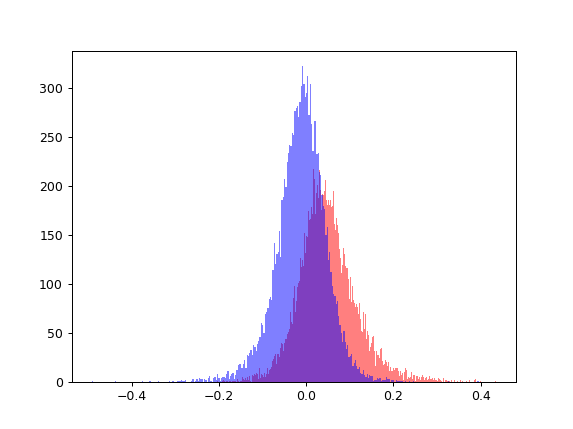

In [17]:
fig, ax = plt.subplots( 1, 1 )
ax.hist( mhblwea_pn_ratio_for_pos_corpus, bins=300 , color='red', alpha=0.5 )
ax.hist( mhblwea_pn_ratio_for_neg_corpus, bins=300 , color='blue', alpha=0.5 )
plt.show()

In [44]:
mhblwea_pn_votes_for_pos_corpus = [
    mhblwea_votes( lemmatized_decontracted_pos_contents[i], positive_lemmas, negative_lemmas, valence_df=valence_df, valence_mean=valence_mean, ntop=20 ) 
    for i in tnrange( len( lemmatized_decontracted_pos_contents ) )
]
mhblwea_pn_votes_for_neg_corpus = [ 
     mhblwea_votes( lemmatized_decontracted_neg_contents[i], positive_lemmas, negative_lemmas, valence_df=valence_df, valence_mean=valence_mean, ntop=20 ) 
     for i in tnrange( len( lemmatized_decontracted_neg_contents ) ) 
 ]

<IPython.core.display.Javascript object>


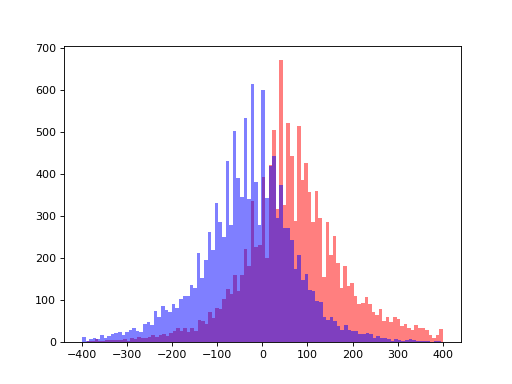

In [46]:
fig, ax = plt.subplots( 1, 1 )
ax.hist( mhblwea_pn_votes_for_pos_corpus, bins=100 , color='red', alpha=0.5 )
ax.hist( mhblwea_pn_votes_for_neg_corpus, bins=100 , color='blue', alpha=0.5 )
plt.show()

In [20]:
mhbl_pn_for_pos_corpus = [
    mhbl_pn_ratio( lemmatized_decontracted_pos_contents[i], positive_lemmas, negative_lemmas ) 
    for i in tnrange( len( lemmatized_decontracted_pos_contents ) )
]
mhbl_pn_for_neg_corpus = [ 
     mhbl_pn_ratio( lemmatized_decontracted_neg_contents[i], positive_lemmas, negative_lemmas ) 
     for i in tnrange( len( lemmatized_decontracted_neg_contents ) ) 
 ]

<IPython.core.display.Javascript object>


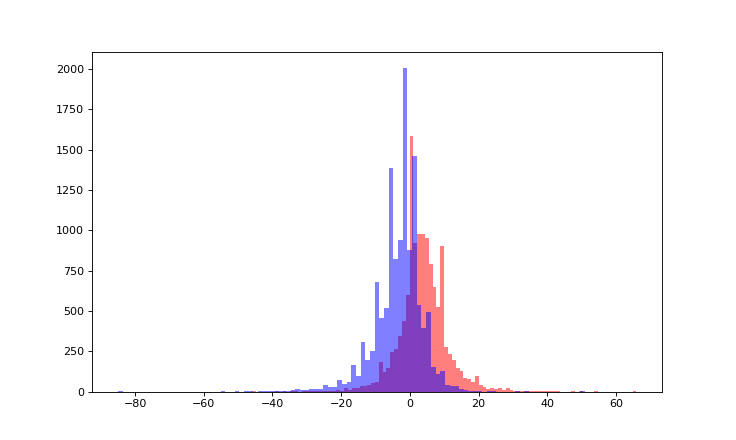

In [47]:
fig, ax = plt.subplots( 1, 1 )
ax.hist( mhbl_pn_for_pos_corpus, bins=100 , color='red', alpha=0.5 )
ax.hist( mhbl_pn_for_neg_corpus, bins=100 , color='blue', alpha=0.5 )
plt.show()

In [48]:
mhbl_pn_votes_for_pos_corpus = [
    mhbl_pn_votes( lemmatized_decontracted_pos_contents[i], positive_lemmas, negative_lemmas ) 
    for i in tnrange( len( lemmatized_decontracted_pos_contents ) )
]
mhbl_pn_votes_for_neg_corpus = [ 
     mhbl_pn_votes( lemmatized_decontracted_neg_contents[i], positive_lemmas, negative_lemmas ) 
     for i in tnrange( len( lemmatized_decontracted_neg_contents ) ) 
 ]

<IPython.core.display.Javascript object>


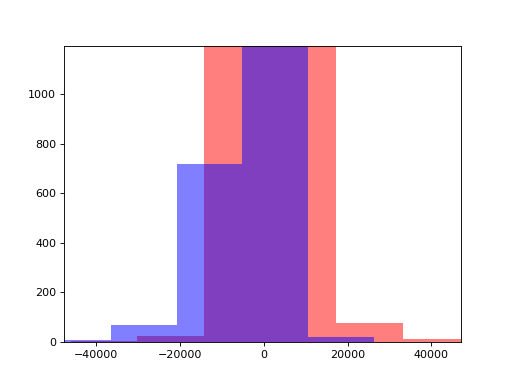

112450 -46046
42075 -115090


In [57]:
fig, ax = plt.subplots( 1, 1 )
print( max( mhbl_pn_votes_for_pos_corpus ) , min( mhbl_pn_votes_for_pos_corpus ) )
print( max( mhbl_pn_votes_for_neg_corpus ) , min( mhbl_pn_votes_for_neg_corpus ) )

ax.hist( mhbl_pn_votes_for_pos_corpus, bins=10 , color='red', alpha=0.5 )
ax.hist( mhbl_pn_votes_for_neg_corpus, bins=10 , color='blue', alpha=0.5 )
plt.show()

In [50]:
len( mhbl_pn_votes_for_pos_corpus )
mhbl_pn_votes_for_pos_corpus[0:10]

[0, 2592, 294, 124, 480, 855, 654, 3340, -4785, 324]

In [ ]:
seed = 42

clf_pipeline = Pipeline(
	[
		('preproc', process( expand_contractions=True, lowercase=True, lemmatize=True, exclude_stopwords=False ) ),
		('vectorize', CountVectorizer() ),
		('tfidf', TfidfTransformer() ),
		('normalize', Normalizer() ),
		('clf', MultinomialNB() )
	]
)

clf_pipeline.fit( Xtrain, ytrain )
ypreds = clf_pipeline.predict( Xtest )
